# GWAS Analysis using Linear Mixed Effect Models

In this tutorial we show you how to use the VarianceComponentModels.jl of the Open Mendel project to do a standard GWAS that accounts for relatedness or population substructure using as a random effect. The data used in this tutorial are from the Mendel version 16.0 option 29 (http://software.genetics.ucla.edu/download?package=1). They are simulated data and are freely available but please acknowledge the Open Mendel project if you use them. Strictly, because the data are only snps on chromosome 19, but with ~140,000 snps you will get an idea of the capabilities of Open Mendel. 

To use this tutorial you will need to have installed SnpArrays, VarianceComponentModels and MendelPlots from the Open Mendel project. To do so, please open julia in a terminal, then use the julia package manager. Add SnpArrays first, then VarianceComponentModels and finally MendelPlots. 

] #invokes the package manager

add https://github.com/OpenMendel/SnpArrays.jl.git

add https://github.com/OpenMendel/VarianceComponentModels.jl.git

add  https://github.com/OpenMendel/MendelPlots.jl.git

You will also need these registered packages, DataFrames, CSV, Distributions, DelimitedFIles, and LinearAlgebra and can add them using the package manager if you haven't already:

add Distributions.jl 

add Delimitedfiles.jl  

add LinearAlgebra.jl

add CSV.jl

add DataFrames.jl


The tutorial has been tested with julia 1.1.0


In [1]:
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6567U CPU @ 3.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 8


### Load Required Packages  

In [2]:
# packages from openMendel
using SnpArrays,VarianceComponentModels
# packages from Julia base
using Distributions, DelimitedFiles, LinearAlgebra

### Read in family structure and trait

In this example we will use one of the two simulated traits found in the fam file.  We will also use sex as a covariate.  In the fam file sex is denoted as F or M.  We arbitrarily chose M (male) to be the reference group and so change M to 0 when we define the sex variable.  The effect of sex is the change in effect size from male to female, which is changed from a coding of F to 1. 

In [3]:
pedLMM = readdlm("SNP_29a.fam", ','; header = false)
Trait1 = convert(Vector{Float64}, pedLMM[:, 7])
# Trait2 = convert(Vector{Float64}, pedLMM[:, 8])
# Y = [Trait1 Trait2]
sex = map(x -> strip(x) == "F" ? 1.0 : 0.0,  pedLMM[:, 5])

212-element Array{Float64,1}:
 1.0
 1.0
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 1.0
 0.0
 1.0
 0.0
 1.0
 ⋮  
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

We can check that the data were read in correctly by typing the name of the variable.

In [4]:
Trait1

212-element Array{Float64,1}:
 29.20564
 31.80179
 37.82143
 35.08036
 28.32902
 36.17929
 42.88099
 40.98316
 35.55038
 48.06048
 37.60566
 46.36752
 35.05782
  ⋮      
 38.85976
 42.21514
 40.26029
 36.09045
 37.72721
 40.46004
 36.59842
 40.16524
 44.12219
 37.79624
 38.9626 
 40.51312

### Read in genotypes and calculate GRM

We use SnpArrays to read in the binary snp file.  We also use SnpArrays to calculate the genetic relationship matrix (GRM). In this example we exclude any snps with a minor allele frequency (maf) less than 0.05. Using SNP with maf >0.05 helps insure that the GRM is accurate because rare variants can bias the GRM. 

In [5]:
snpbinLMM = SnpArray("SNP_29a.bed")
ex29agrm = grm(snpbinLMM; method = :GRM, minmaf=0.05)

212×212 Array{Float64,2}:
  0.498264     0.0080878    0.0164327   …   0.0246825    0.00181856
  0.0080878    0.498054    -0.0212599      -0.0285927   -0.0226525 
  0.0164327   -0.0212599    0.499442       -0.0219661   -0.00748536
  0.253627    -0.00160532   0.282542        0.00612693  -0.00339125
  0.126098     0.253365     0.128931       -0.0158446   -0.00633959
 -0.014971    -0.00266073  -0.00243384  …   0.00384757   0.0145936 
 -0.0221357    0.0100492   -0.0107012      -0.0148443   -0.00127783
 -0.01629     -0.00749253  -0.015372       -0.0163305   -0.00258392
 -0.016679     0.00353587  -0.0128844      -0.0332489   -0.00707839
 -0.0176101   -0.00996912  -0.0158473      -0.00675875  -0.0122339 
 -0.0162558    0.00938592   0.0064231   …  -0.00510882   0.0168778 
 -0.0167487    0.00414544  -0.00936538     -0.0134863    0.0020952 
 -0.031148     0.00112387  -0.010794        0.00383105   0.0198635 
  ⋮                                     ⋱   ⋮                      
 -0.00865735  -0.00335

We need to know the order of the snps in the bed file so we read in the bim file.  Of course we need to exclude those with maf >0.05 to match the set of snps we used in the GRM.

In [6]:
# columns are: :chrom, :snpid, :?, :pos, :allele1, :allele2
snpLMM = readdlm("SNP_29a.bim"; header = false)
snpLMM = snpLMM[maf(snpbinLMM) .> 0.05,:]
snpid = map(x -> strip(string(x)), snpLMM[:, 2])

137741-element Array{SubString{String},1}:
 "rs56343121" 
 "rs56182540" 
 "rs7260412"  
 "rs8106297"  
 "rs8106302"  
 "rs186451972"
 "rs76534612" 
 "rs1975526"  
 "rs62103026" 
 "rs62103027" 
 "rs67286684" 
 "rs59441037" 
 "rs57114567" 
 ⋮            
 "rs140264059"
 "rs62114717" 
 "rs188169422"
 "rs139879509"
 "rs143250448"
 "rs145384750"
 "rs149215836"
 "rs139221927"
 "rs181848453"
 "rs186913222"
 "rs141816674"
 "rs150801216"

### Setting up the data for the covariates.  I
In this case we have only sex as a covariate but we could have used other covariates as desired. The ones(n) sets of a variable that has value 1.0 for all individuals. This is the grand mean $\mu$.

In [7]:
n, snps = size(snpbinLMM[:,maf(snpbinLMM) .> 0.05])
X = [ones(n) sex]
p = size(X,2)  # no. covariates
n, snps, p

(212, 137741, 2)

### Prepare to fit LmmGWAS

First we analyze the data under the null model of no snp effects. The next three commands set up the data.  Then we need to decide which algorithm we wish to use to get our estimates. We have chosen the MM algorithm. Alternatively we could have used Fisher scoring (FS). The next set of commands then implements the optimization.  

In [10]:
# fit null model once to store nessary information for alternative model 
nulldata    = VarianceComponentVariate(Trait1, X, (2ex29agrm, Matrix{Float64}(I, n, n)))
nulldatarot = TwoVarCompVariateRotate(nulldata)
nullmodel   = VarianceComponentModel(nulldata)

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([0.0; 0.0], ([1.0], [1.0]), Array{Float64}(0,2), Char[], Float64[], -Inf, Inf)

In [11]:
algorithm = :MM

:MM

In [12]:
if algorithm == :MM
    logl_null,_,_,Σcov, = mle_mm!(nullmodel, nulldatarot; verbose = true)
elseif algorithm == :FS
    logl_null,_,_,Σcov, = mle_fs!(nullmodel, nulldatarot; verbose = true)
end


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.487551e+05

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

       1  -6.257354e+02
       2  -5.420582e+02
       3  -5.116720e+02
       4  -5.006695e+02
       5  -4.957735e+02
       6  -4.927804e+02
       7  -4.905160e+02
       8  -4.886679e+02
       9  -4.871412e+02
      10  -4.858883e+02
      20  -4.813052e+02
      30  -4.807972e+02
      40  -4.807340e+02
      50  -4.807255e+02
      60  -4.807244e+02
      70  -4.807242e+02



(-480.72419822635567, VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([40.1916; -6.29444], ([4.87898], [1.92549]), Array{Float64}(0,2), Char[], Float64[], -Inf, Inf), ([1.05478], [0.559104]), [1.11255 -0.407883; -0.407883 0.312597], [0.172756; 0.31492], [0.0298447 -0.0453772; -0.0453772 0.0991749])

### Heritablity of `Trait1`

We now calculate the narrow sense heritability and its standard error.   The equation for heritability(h) is h = $\sigma^2_a / (\sigma^2_a + \sigma^2_e)$.  Note that in this version of the VarianceComponentModels.jl, we allow for only two variance components, the additive genetic variance and the dependent environmental variance.  In future implementations we will allow for more variance components.  

In [13]:
h, hse = heritability(nullmodel.Σ, Σcov)

([0.717026], [0.0622537])

The heritability of this simulated trait is rather on the high side ($72\%$) for a human trait, which explains why we can get away with only 212 individuals in this GWAS. 

## GWAS of Trait1

We now prepare our alternative models in order to conduct our GWAS of Trait1:

In [14]:
## fit alternative model with SNPs, push null model info to alternative model 
T = eltype(sex)
altdatarot = TwoVarCompVariateRotate(nulldatarot.Yrot,
    zeros(T, n, size(X, 1) + 1), nulldatarot.eigval, nulldatarot.eigvec,
    nulldatarot.logdetV2)
copyto!(altdatarot.Xrot, nulldatarot.Xrot) # last column ramains zero
altmodel = VarianceComponentModel(altdatarot)

VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}([0.0; 0.0; … ; 0.0; 0.0], ([1.0], [1.0]), Array{Float64}(0,213), Char[], Float64[], -Inf, Inf)

### Loop over all SNPs to calculate LRT pvalues for LmmGWAS

The following routine shows you how you can write some simple julia code to execute a GWAS. This tutorial is set up to run all the snps. Note that if you are running this tutorial on your old laptop, then be prepared to wait a while for this step to finish. If you see the counter (for every 1000 snps processed) progressing, then the program is working so just be patient.  Alternatively you might wish to try out the tutorial for a much smaller example.  Then loop through only the first few snps, for example the first 100. If so, comment out with a # "@time for snp in 1:snps" and remove the # on "@time for snp in 1:testrun"

In [15]:
pvalue   = ones(snps)
genovec  = zeros(T, n)
testrun  = 100

snpsidx = vcat(1:size(snpbinLMM,2))[maf(snpbinLMM) .> 0.05]
# @time for snp in 1:testrun
@time for snp in 1:snps 
    # append (rotated) genotype vector to covariate matrix
    Base.copyto!(genovec, @view(snpbinLMM[:,snpsidx[snp]]), model=ADDITIVE_MODEL, center=true, scale=true, impute=true)
    tmp_mat = similar(genovec)
    LinearAlgebra.mul!(tmp_mat, transpose(altdatarot.eigvec), genovec)
    altdatarot.Xrot[:, end] = tmp_mat
    # initialize mean effects to null model fit
    fill!(altmodel.B, zero(T))
    copyto!(altmodel.B, nullmodel.B)
    copyto!(altmodel.Σ[1], nullmodel.Σ[1])
    copyto!(altmodel.Σ[2], nullmodel.Σ[2])
    # fit alternative model
    if algorithm == :MM
        logl_alt, vcmodel_mle, Σse, Σcov, Bse, Bcov = mle_mm!(altmodel, altdatarot; verbose = false)
    elseif algorithm == :FS
        logl_alt, = mle_fs!(altmodel, altdatarot; verbose = false)
    end
    # LRT statistics and its pvalue
    lrt = - 2(logl_null - logl_alt)
    pvalue[snp] = ccdf(Chisq(1), lrt)
#    println(snp,": ", hapmap_snpdata.snpid[snp], 
    if mod(snp, 1000) == 1
            println(snp)
    end    
#        "\n\tMAF: ", @sprintf("%0.3f", maf[snp]), 
#        "\n\tLRT p: ", @sprintf("%0.3f", pvalue[snp]))
end


1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
12001
13001
14001
15001
16001
17001
18001
19001
20001
21001
22001
23001
24001
25001
26001
27001
28001
29001
30001
31001
32001
33001
34001
35001
36001
37001
38001
39001
40001
41001
42001
43001
44001
45001
46001
47001
48001
49001
50001
51001
52001
53001
54001
55001
56001
57001
58001
59001
60001
61001
62001
63001
64001
65001
66001
67001
68001
69001
70001
71001
72001
73001
74001
75001
76001
77001
78001
79001
80001
81001
82001
83001
84001
85001
86001
87001
88001
89001
90001
91001
92001
93001
94001
95001
96001
97001
98001
99001
100001
101001
102001
103001
104001
105001
106001
107001
108001
109001
110001
111001
112001
113001
114001
115001
116001
117001
118001
119001
120001
121001
122001
123001
124001
125001
126001
127001
128001
129001
130001
131001
132001
133001
134001
135001
136001
137001
10560.454808 seconds (753.23 M allocations: 1.388 TiB, 1.73% gc time)


### Output results to file
In some situations you may want to save GWAS results for future use, for example for use as part of a meta analysis. In the next set of commands, we show you how to make and save a comma delimited file with the snp id, the position of the snp, the chromosome location of the snp, the minor allele frequency, and the result provided as the negative log of the p-value. 

In [16]:
using DataFrames
using CSV

In [17]:
# maf, = summarize(snpbinLMM)
plot_frame = DataFrame(snpid = snpLMM[:,2],
   AdjBasepairs = snpLMM[:,4], 
   Chromosome = snpLMM[:,1], 
   MAF = maf(snpbinLMM)[maf(snpbinLMM).>0.05],
   NegativeLogPvalue = pvalue)

CSV.write("lmmGWAS_output_pVal.txt", plot_frame)

"lmmGWAS_output_pVal.txt"

### Manhattan Plot

One of the most common ways to display the results of a GWAS is as a plot of negative log base 10 of the pvalues versus chromosomal position, a Manhattan plot.  For your convenience, we have developed a Julia plotting module as part of the Open Mendel project, MendelPlots.  We demonstrate its use below.  The Manhattan plot will look at little different than the typical one because this example only includes markers from chromosome 19. 

In [18]:
plot_frame = CSV.read("lmmGWAS_output_pVal.txt")

,snpid,AdjBasepairs,Chromosome,MAF,NegativeLogPvalue
,String⍰,Int64⍰,Int64⍰,Float64⍰,Float64⍰
1,rs56343121,91106,19,0.0825472,0.0897149
2,rs56182540,95981,19,0.0872642,0.582401
3,rs7260412,105021,19,0.0849057,0.524435
4,rs8106297,107958,19,0.0589623,0.977626
5,rs8106302,107962,19,0.0589623,0.670749
6,rs186451972,108003,19,0.0849057,0.784671
7,rs76534612,226776,19,0.490566,0.373017
8,rs1975526,240867,19,0.419811,0.749416
9,rs62103026,244421,19,0.436321,0.576142


In [19]:
using MendelPlots

manhattan(plot_frame; pvalvar = "NegativeLogPvalue", chrvar = "Chromosome", 
    posvar = "AdjBasepairs", outfile = "lmmGWAS_manhattan.pdf", fontsize = 18pt, linecolor = "red")


┌ Info: Precompiling MendelPlots [7ab2ea78-72dd-4c03-85d8-fc2b0db252af]
└ @ Base loading.jl:1186
┌ Info: Loading Cairo backend into Compose.jl
└ @ Compose /Users/janets/.julia/packages/Compose/wlPCt/src/Compose.jl:164
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/janets/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


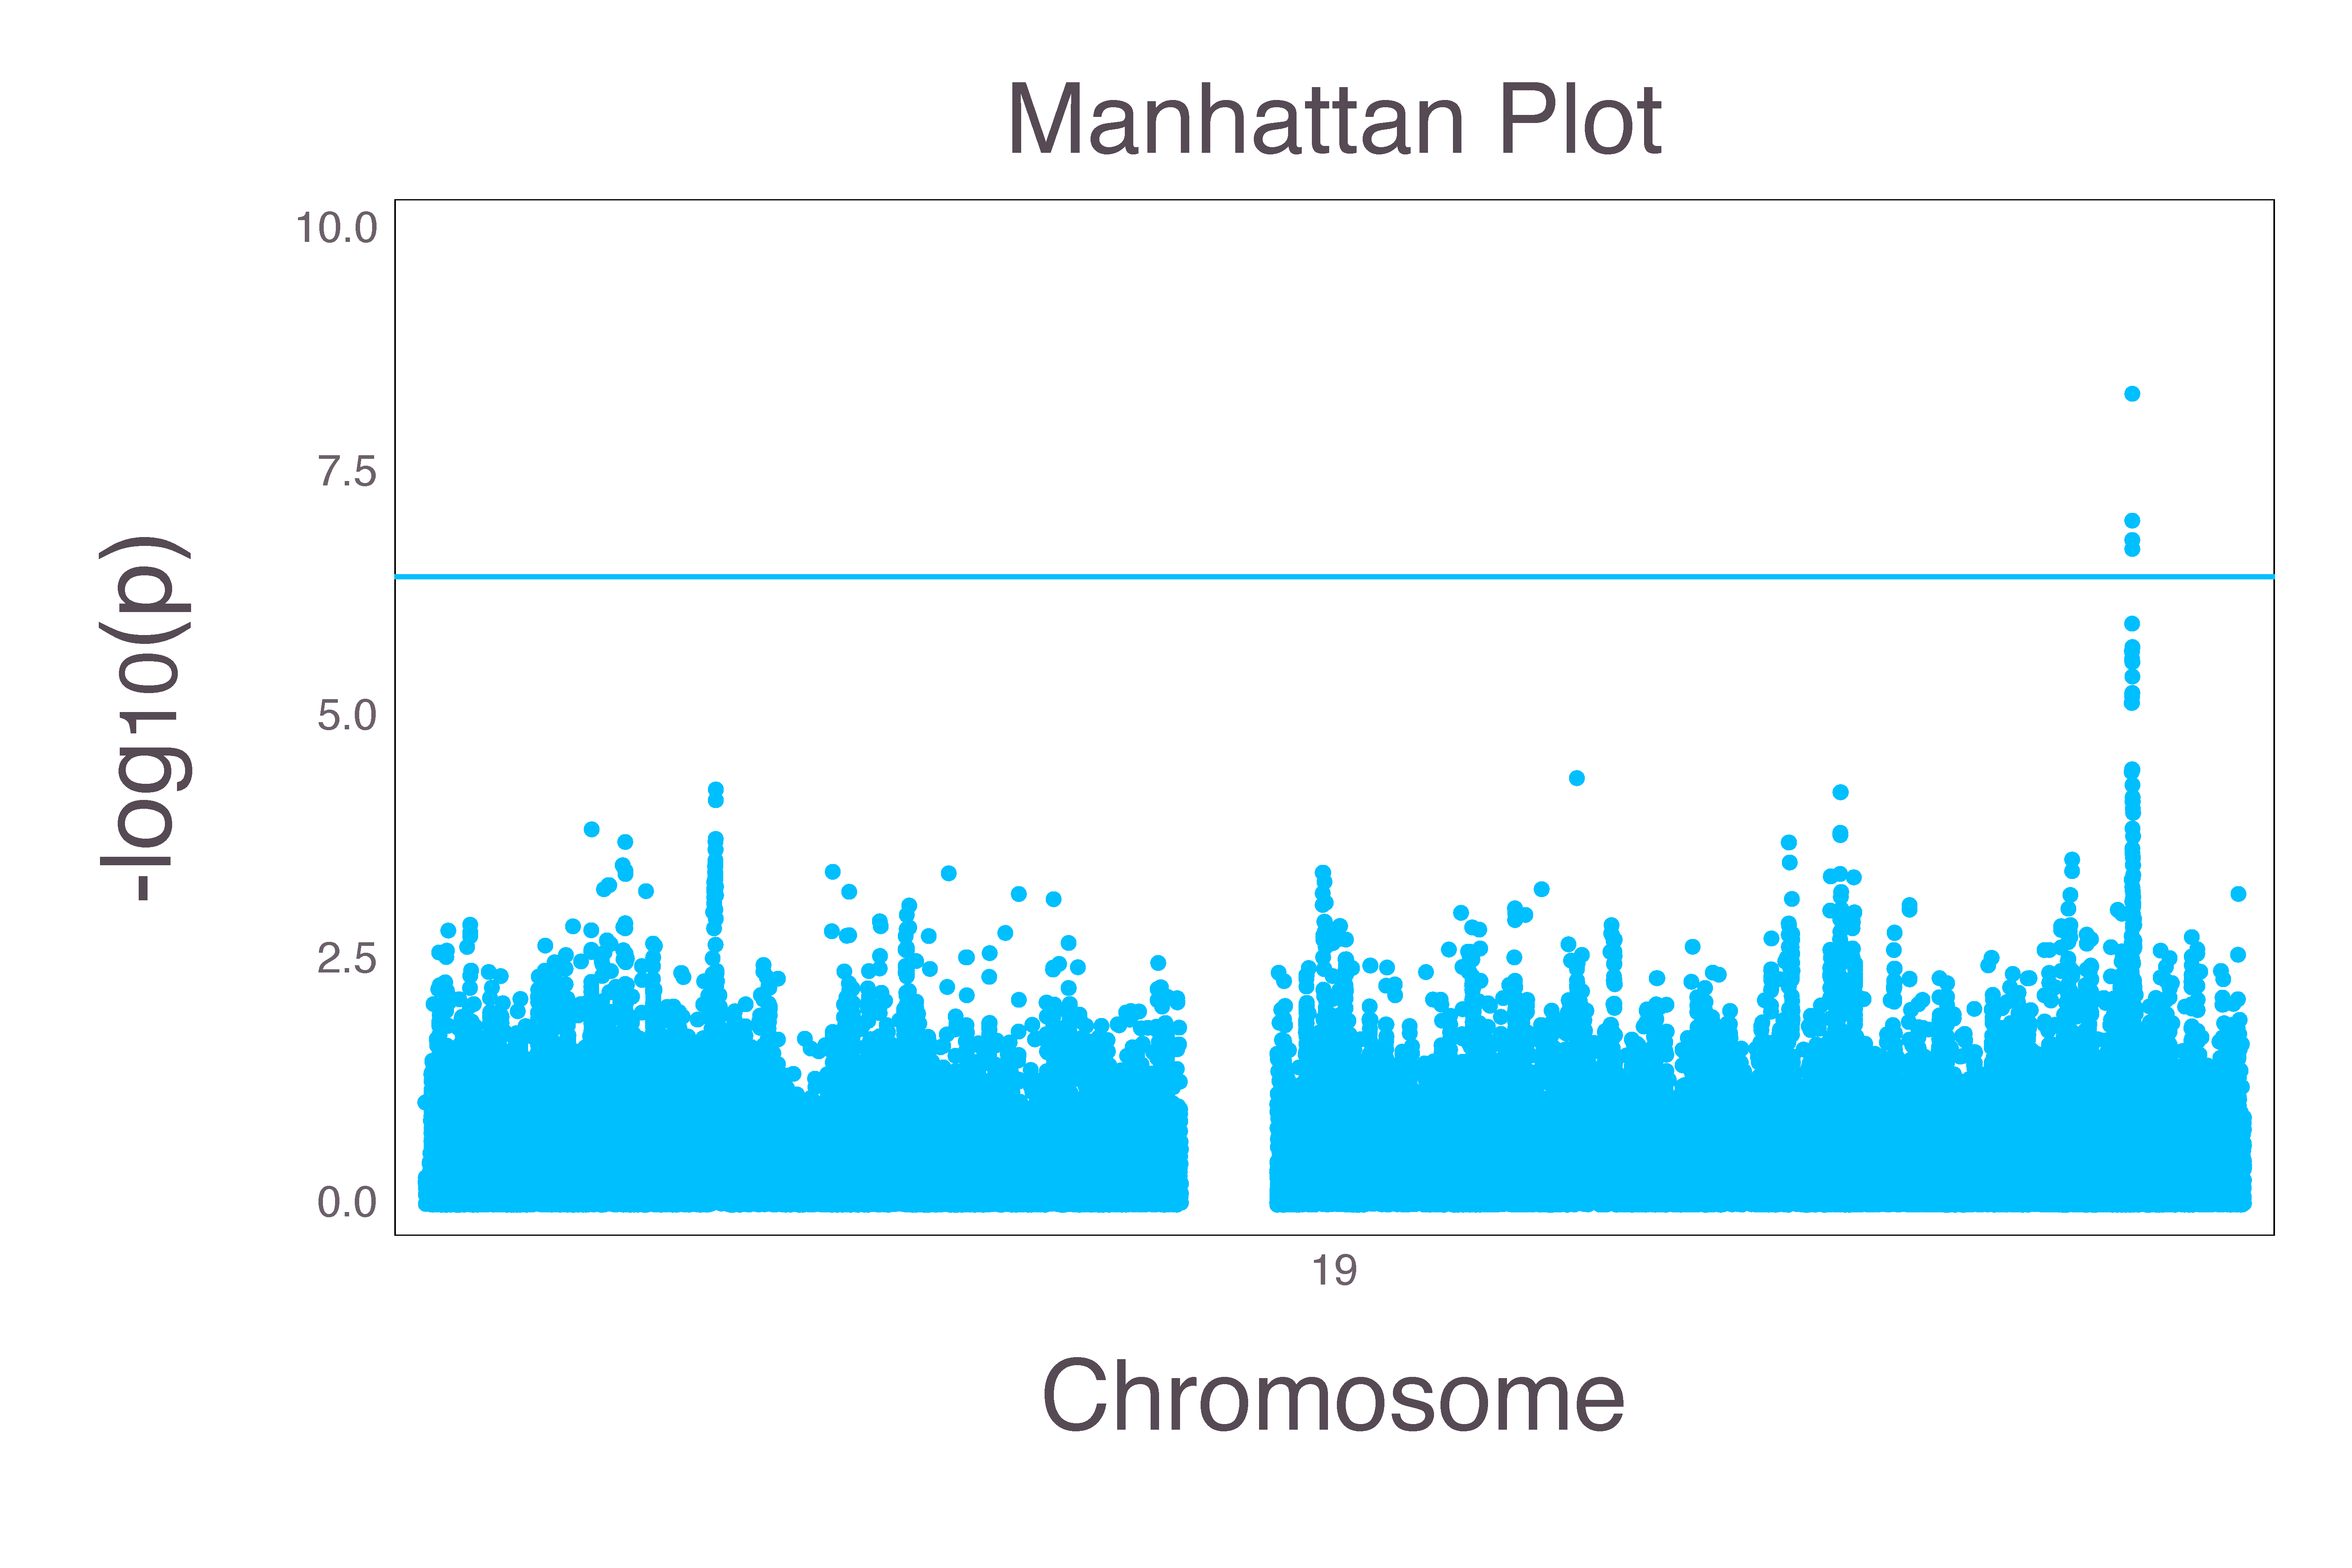

In [20]:
 display("image/png", read("lmmGWAS_manhattan.png")) 

## Conclusions

This tutorial demonstrates how with just a little extra Julia coding, an Open Mendel user can use the VarianceComponentModels module to conduct a GWAS that takes into account possible relatedness or population substructure among individuals as a random effect.  